# SPARKIFY

We started this project with data from a company called sparkify. It sounds like spotify but the intention is just to conduct a data science study with Spark. The company doesn exist but the data are real and massive. There is one huge 12 GB dataset, and a medium 128MB dataset. Either way, distributed computing is convenient for analyzing such a large amount of data. Here, we decide to work with the medium dataset for ease of speed and money. 

Our project and calculation is hosted by IBM cloud. We use the PySpark API for working with the Spark kernel.  

**The purpose of this study is to find out what users are most likely to churn their subscription?** Ultimately, the company could use targeted advertisement to keep the users on the platform.

We will proceed in 5 steps:
 - 1. Spark set up
 - 2. Data cleaning
 - 3. Exploration and  Data Analysis
 - 4. Feature engineering 
 - 5. Modeling 
 - 6. Summary

# 1. Spark Set Up

- **Install libraries** that are not part of the Python kernel but needed.

In [1]:
!pip install wordcloud;

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210517204556-0001
KERNEL_ID = d75d5e3a-88c3-4569-9901-e7617fbb5413
  Using cached wordcloud-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (366 kB)
  Using cached numpy-1.20.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.3 MB)
  Using cached Pillow-8.2.0-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
  Using cached matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.0 which is incompatible.


- **Import Python libraries needed** for the rest of the study

In [2]:
# PySpark libraries
from pyspark.sql import SparkSession 
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from ibm_botocore.client import Config
import pyspark.sql.functions as F

# data management and calculation libraries
import pandas as pd
import numpy as np

# visualization libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

# data loading libraries
from ibm_botocore.client import Config
import ibm_boto3
import ibmos2spark
import os

- **Start the spark session**. It is the entry point to programming Spark with the Dataset and Dataframe API.

In [3]:
if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_440a2242de224ac3ae24a5fe634abd2c = 'https://s3.eu-geo.objectstorage.softlayer.net'
else:
    endpoint_440a2242de224ac3ae24a5fe634abd2c = 'https://s3.eu-geo.objectstorage.service.networklayer.com'

credentials = {
    'endpoint': endpoint_440a2242de224ac3ae24a5fe634abd2c,
    'service_id': 'iam-ServiceId-223ecf89-2a86-443f-a664-d1a314987d02',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'gtZNw5vyfuM6h_NRXR1piEkYVHg3XQr5x3_o9zsDTyiK'
}
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.

configuration_name = 'os_440a2242de224ac3ae24a5fe634abd2c_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

# start Spark session 
spark = SparkSession.builder.getOrCreate()

- **Load data from cloud storage**. 
- We read the data from a JSON file, as they were given to us.

In [4]:
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-223ecf89-2a86-443f-a664-d1a314987d02',
    'IBM_API_KEY_ID': 'gtZNw5vyfuM6h_NRXR1piEkYVHg3XQr5x3_o9zsDTyiK',
    'ENDPOINT': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'toto-donotdelete-pr-zym3eigdu4oc9f',
    'FILE': 'mini_sparkify_event_data.json'
}

df = spark.read.json(cos.url('medium-sparkify-event-data.json', credentials_1['BUCKET']))

# 2. Data Cleaning

Here we **load the data and try to understand the content**. Our data are already quiet small and handy so we can use it as it is. However, if we had to work with a bigger dataset, It would make sense to consider a subset first. We want to find out a repeatable and stable procedure for cleaning up data from invalid or missing inputs. The idea is to be able to reuse it confidently on new or bigger datasets for the same purpose. 

 - **We display the first 5 rows**. It gived us a tangible idea of the kind of data we will be dealing with.

In [5]:
# determin the data size
print(f"there are {df.count()} lines and {len(df.columns)} columns")

# display the first 5 rows in dataframe
df.take(5)

there are 543705 lines and 18 columns


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

- **We print the dataframe schema.**
- The data frame´s schema reveals the data type of each column. At a glance, we can already see that the type matches up with the above values pretty well. There is no inconsistency. Numerical data are considered numerical and the rest are stored as strings. 
- However, the "ts" column can be converted into timestamps directly. There is a special type for that.
- It is better to keep userID as a string because a conversion into an integer may overflow if the number of users is too high

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df = df.withColumn("ts",F.to_timestamp(F.col("ts")/1000))

- **We check the cardinality of quantitative and categorical data, and count missing values**. Once compared to the examples above, It tells a lot about the latent of relationship between  the columns. 

> For instance, there are a lot more songs than users or artists because an artist can produce many songs and a user can listen to many songs. The number of users and registration seem to be equivalent, maybe redundant. The number of distinct locations is quite large as they can hold several users. 

- From here we can also consider what kind of data can be used for Machine Learning: Numerical data or non- numerical data with low cardinality (gender, level). The last ones can be encoded. For remaining data such as strings, we would need to consider feature extraction.

- The same number of missing values across the different columns suppose some correlation between missing features. 



In [8]:
# identify data types
types_df = pd.DataFrame(df.dtypes, columns=['variable', 'dtypes'])
types_df['is_numeric'] = types_df['dtypes'] != 'string'

# keep track of different data types 
numerical_col = types_df[types_df['is_numeric']]['variable'].tolist()
categorical_col = types_df[~types_df['is_numeric']]['variable'].tolist()

# count cardinality for each column
cardinality_df = df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in df.columns)).toPandas()
cardinality_df = cardinality_df.T.reset_index().rename(columns={'index':'variable', 0:'cardinality'})
cardinality_df = cardinality_df.rename(columns={0:'cardinality'})
cardinality_df = cardinality_df.sort_values(by='cardinality')

# count of missing values for each columns
missing_df = df.select([F.count(F.when(F.col(c).isNull() , c)).alias(c) for c in df.columns]).toPandas()
missing_df = missing_df.T.reset_index().rename(columns={'index':'variable', 0:'is_Null'})
missing_df = missing_df.rename(columns={0:'is_Null'})
missing_df = missing_df.sort_values(by='is_Null')

# merge data type table with cardinality counts
card_type_pdf = types_df.merge(cardinality_df.merge(missing_df, on='variable'), on='variable').\
                            groupby(['is_numeric', 'variable']).max()
card_type_pdf.sort_values(by=['is_numeric','cardinality'])

dtypes  cardinality  is_Null
is_numeric variable                                      
False      gender            string            2    15700
           level             string            2        0
           method            string            2        0
           auth              string            4        0
           page              string           22        0
           userAgent         string           71    15700
           location          string          192    15700
           lastName          string          275    15700
           firstName         string          345    15700
           userId            string          449        0
           artist            string        21247   110828
           song              string        80292   110828
True       status            bigint            3        0
           registration      bigint          448    15700
           itemInSession     bigint         1006        0
           sessionId         bigint         4590        0
           length            double        16679   110828
           ts             timestamp       513108        0

- **We display the content of the first group with 15700 missing values**. 
- it impacts the following features all together: gender, userAgent, location, lastName, firstName, and registration.
- It turns out that the userId is also missing but represented as an empty string. We can conclude that this group of data actually corresponds to users who never signed in. Later we can remove them as they dont bring information to our problem. We are interested in users who once subscribed and then resigned. Still, considering our goal, we can consider removing the first name and the last name. It should have no impact on cancellation. Instead, the userId is enough.

In [9]:
error_count = 15700

missing_col = missing_df[missing_df['is_Null'] == error_count]['variable'].tolist()
condition = condition = F.lit(False)
for col in missing_col:
    condition |= df[col].isNull()
df.select(*df.columns).filter(condition).take(5)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=186, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=178, song=None, status=200, ts=datetime.datetime(2018, 10, 1, 0, 2, 28), userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=187, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=178, song=None, status=200, ts=datetime.datetime(2018, 10, 1, 0, 2, 31), userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=188, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=178, song=None, status=200, ts=datetime.datetime(2018, 10, 1, 0, 2, 48), userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=189, lastName=None, len

- **We display the content of the second group with 110828 missing values**. 
- it impacts the following features all together: artist, song, length. 
- After further analysis, we realize that it happens when the user escapes the music player for visiting other pages. The music stops but not always . The "Next Song" page is never affected as it supports the player's activities.
- In this case, this behavior is normal so missing values should be considered.


In [10]:
error_count = 110828

missing_col = missing_df[missing_df['is_Null'] == error_count]['variable'].tolist()
condition = F.lit(False)
for c in missing_col:
    condition |= df[c].isNull()
    
df.select(*df.columns).filter(condition).take(5)

[Row(artist=None, auth='Logged In', firstName='Maverick', gender='M', itemInSession=185, lastName='Santiago', length=None, level='paid', location='Orlando-Kissimmee-Sanford, FL', method='PUT', page='Logout', registration=1535953455000, sessionId=178, song=None, status=307, ts=datetime.datetime(2018, 10, 1, 0, 1, 59), userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='179'),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=186, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=178, song=None, status=200, ts=datetime.datetime(2018, 10, 1, 0, 2, 28), userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=187, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=178, song=None, status=200, ts=da

In [11]:
def column_repr(column_list):
    """represent content from a column list generated via pyspark collect function"""
    for row in column_list:
        print("\t" + row[0])
        
# display pages where artist, song, and length go missing
print("pages visited while music stopped")
column_repr(df.filter(condition).select("page").distinct().collect())

#display the rest of the pages where where music keeps running
print("pages visited while music playing")
column_repr(df.filter(~condition).select("page").distinct().collect())

pages visited while music stopped
	Cancel
	Submit Downgrade
	Thumbs Down
	Home
	Downgrade
	Roll Advert
	Logout
	Save Settings
	Cancellation Confirmation
	About
	Submit Registration
	Settings
	Login
	Register
	Add to Playlist
	Add Friend
	Thumbs Up
	Help
	Upgrade
	Error
	Submit Upgrade
pages visited while music playing
	NextSong


- the “page” column is certainly the most determinant one for our future work. The answer to our problem is indeed in this column. We want to identify the users who churn their subscription. In other words, we want to identify those who once visited the page “Cancellation Confirmation”. 

- **We display the visit count for each page**. The” Next Song” page is by far the most visited page: 432877. In contrast, only a hundred users visited confirmed their cancellation. 

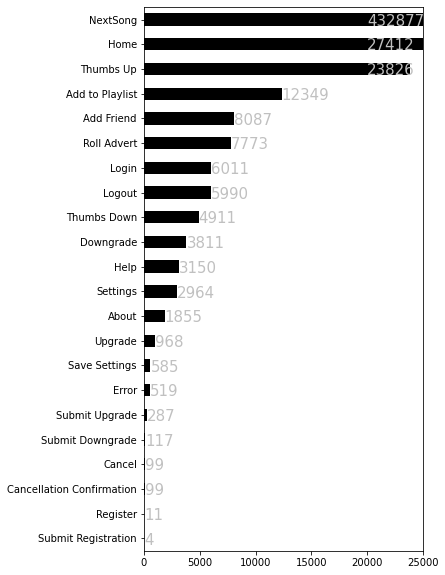

In [12]:
#count the number of visit per page
page_type_df = df.select('page').groupBy('page').count().toPandas()

# display the visit count with a barplot
ax = page_type_df.sort_values(by='count')\
    .plot(kind='barh', x='page', y='count', xlim=(0,25000), legend=False, figsize=(5,10), color='black')
ax.yaxis.label.set_visible(False)
for i in ax.patches:
    ax.text(min(i.get_width()+.3,20000), i.get_y(), str(i.get_width()), fontsize=15, color='silver')

- It is important to understand what is the unique identifier for each entry in the data frame. What is the primary key? 
- **We combine both “userId“ and “sessionId“ together and check if it is enough information to target a single row in the dataframe** . It is not enough. There are actually more than one entry for each group of “userId“ and “sessionId“. We need more...
- **Possible primary key**:
    - userId, sessionId, and itemInSession
    - userId, sessionId, and ts

In [13]:
# group by userId and sessionId and count if ithols more than one entry
example_pdf = df.groupby(["userId", "sessionId"]).count().where(F.col('count') > 1).sort('count', ascending=False).toPandas()
example_pdf.head(5)

,userId,sessionId,count
0,105,1052,987
1,246,2860,912
2,86,3425,884
3,153,4131,873
4,244,2470,799


In [14]:
# print the first group from the above dataframe (line 0)
example_userId = example_pdf['userId'].iloc[0]
df.select('userId','sessionId', 'itemInSession', 'firstName','lastName','gender','ts','page')\
    .filter(F.col('userId')==example_userId).show()

+------+---------+-------------+---------+--------+------+-------------------+--------+
|userId|sessionId|itemInSession|firstName|lastName|gender|                 ts|    page|
+------+---------+-------------+---------+--------+------+-------------------+--------+
|   105|      104|            0|Alexander|  Garcia|     M|2018-10-02 20:08:38|    Home|
|   105|      104|            1|Alexander|  Garcia|     M|2018-10-02 20:10:00|NextSong|
|   105|      104|            2|Alexander|  Garcia|     M|2018-10-02 20:13:21|NextSong|
|   105|      104|            3|Alexander|  Garcia|     M|2018-10-02 20:15:35|NextSong|
|   105|      104|            4|Alexander|  Garcia|     M|2018-10-02 20:20:30|NextSong|
|   105|      104|            5|Alexander|  Garcia|     M|2018-10-02 20:24:48|NextSong|
|   105|      104|            6|Alexander|  Garcia|     M|2018-10-02 20:28:19|NextSong|
|   105|      104|            7|Alexander|  Garcia|     M|2018-10-02 20:33:22|NextSong|
|   105|      104|            8|

 - Now we have a better insight on our data.
 - **It is time to clean up. We will set up a function that could be reused on larger datasets.**

- Our main takeaways are:
    - users are useless when they have no userId (i.e. never subscribed).
    - first name and last do not serve our purpose.
    - we can remove duplicates by checking what we consider to be the primary key.

In [15]:
def clean_up(df):
    """clean up the dataframe from missing values and duplicated data"""
    
    clean_df = df.where(df['userId']!='')\
            .dropna(how='any', subset=['userId', 'sessionId'])\
            .dropDuplicates(["userId", "sessionId", "itemInSession"])\
            .drop('fristName', 'lastName')
    return clean_df

- **We clean the dataframe** according to the principles edicted above.

In [16]:
# clean  dataframe 
clean_df = clean_up(df)

# 3. Exploration and  Data Analysis

In this section, we will explore the data in depth. We want to identify business related information that could be useful for inflecting the business strategy of the company. Beforehand, it is important to expose what will soon become our prediction target: the churn point. Then we will be able to explore the data accordingly. 

## Define Churn

- Once we've done some preliminary analysis, **we create a  “churn” column  to become  the  future label of our model**. The new column should contain binary values: 1 for all entries corresponding to a user who churned its contract, and 0 otherwise.
- We create a fucntion for having the procedure consistent with our definition.

In [17]:
def tag_churn_users(df):
    """ Identify when the user subscribes till he unsubscribes by looking ofr the churn point """
    
    # set downgraded column to 1 when visited page is cancellation confirmation, and 0 otherwise
    flag_downgrade_event = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("cancelled", flag_downgrade_event("page"))

    # slice users into partition and set the whole partition to 1 for users who cancelled/downgrded
    df = df.withColumn("churn", F.max("cancelled").over(Window.partitionBy('userId')))
    
    return df

In [18]:
# create churn dataframe
churn_df = tag_churn_users(clean_df)

- **We check if the identification/tagging worked properly**. For users who cancelled, the new  “churn” column should be set to one from the very first time the user uses the  streaming platform until he leaves the platform for good.
- For display conveniency, we carefully pick up some users with a few entries.  

In [19]:
# we look for users who cancelled their subscription
downgrading_users_df = churn_df.groupBy("userId").agg(F.count("userId").alias("count"), F.max(F.col("cancelled")).alias("is_canceling")).\
                            filter(F.col("is_canceling") == 1)

# among those users, we look for the one with the minimum use
min_count = downgrading_users_df.agg({'count':'min'}).alias('min_count').collect()[0][0]

# get the userId of the user who used the platform the least and cancelled
example_df = downgrading_users_df.select("userId", "count").filter(F.col("count") == min_count).toPandas()

example_df.head()

,userId,count
0,100032,13


In [20]:
# display the complete activity of the user found previously
example_userId = example_df['userId'].iloc[0]
churn_df.select('userId','sessionId', 'itemInSession','gender','ts', 'level', 'page','song', 'cancelled', 'churn')\
    .filter(F.col('userId')==example_userId).orderBy('ts').show()

+------+---------+-------------+------+-------------------+-----+--------------------+--------------------+---------+-----+
|userId|sessionId|itemInSession|gender|                 ts|level|                page|                song|cancelled|churn|
+------+---------+-------------+------+-------------------+-----+--------------------+--------------------+---------+-----+
|100032|       32|            0|     M|2018-10-04 09:28:21| free|            NextSong|Meet Me On The Eq...|        0|    1|
|100032|       32|            1|     M|2018-10-04 09:29:33| free|         Roll Advert|                null|        0|    1|
|100032|       32|            2|     M|2018-10-04 09:32:05| free|            NextSong|What's Going On (...|        0|    1|
|100032|       32|            3|     M|2018-10-04 09:32:32| free|         Roll Advert|                null|        0|    1|
|100032|       32|            4|     M|2018-10-04 09:36:40| free|            NextSong|        Tu Presencia|        0|    1|
|100032|

## Explore Data
Now we've defined  the “churn” column, we perform some exploratory data analysis to compare the behavior of users who stayed vs users who churned. We can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played...

- Since we were able to identify users who churned their subscriptions, we will refer to them as **Positive (pos)** users for the sake of simplicity. 
- Naturally, **Negative (neg)** users are the remaining ones, those who did not quit the platform. 

### What is the OS impact on the churning rate ? 

   - **We extract the name of the OS from the “userAgent” column**. 
   - Form there we can **count how many users of each kind (positive and negative) use each OS** and determine if it has an influence on users churning their subscription. The user experience could be different. 

In [21]:
# extract the the name of the OS from  userAgent
churn_df = churn_df.withColumn('OS', F.regexp_extract(F.col('userAgent'), r"\(([\w\d\s.]+)(;|\))", 1))

# count the number of users using each OS
users_os_pdf = churn_df.groupBy('OS').pivot('churn').agg(F.countDistinct(F.col("userId")).alias("churn")).toPandas().fillna(0)

In [22]:
# rename columns
users_os_pdf = users_os_pdf.rename(columns={"0":"neg_counts", "1":"pos_counts"})

# calculate total user count for OS
users_os_pdf['total'] = users_os_pdf['neg_counts'] + users_os_pdf['pos_counts']

# caluclate churn percentage (positive/total)
users_os_pdf['churn_percentage'] = 100 * users_os_pdf['pos_counts'] / users_os_pdf['total']

# sort dataframe for display
users_os_pdf = users_os_pdf.sort_values(by="total", ascending = False)

   - **We plot the platform  activity distribution across platforms**.
   - It is apparent that **the majority of users are on Macintosh or Windows NT 6.1 (aka Windows 7)**.  For those 2 and most of the remaining platforms, the churning rate is between 15% and 20%. There are 2 exceptions though: **0% of IPAD users churned their subscription. On the other side, up to 60% of Iphone users churned their subscription**. 

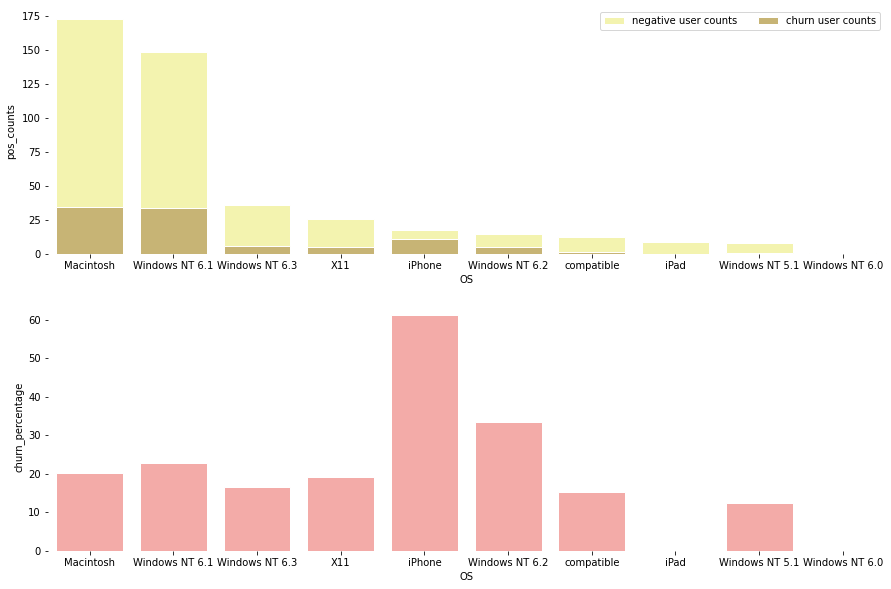

In [23]:
f, ax = plt.subplots(2,1,figsize = (15,10))

# upper bar plot of positive user s count against total user s count 
sns.set_color_codes('pastel')
sns.barplot(x='OS', y='total', data=users_os_pdf, \
            label='negative user counts', color='y', edgecolor='w', ax=ax[0])

sns.set_color_codes('muted')
sns.barplot(x='OS', y='pos_counts', data=users_os_pdf, \
            label='churn user counts', color='y', edgecolor='w', ax=ax[0])

#bottom bar plot of churn percentage
sns.set_color_codes('pastel')
sns.barplot(x='OS', y='churn_percentage', data=users_os_pdf, \
            label='churn percentage', color='r', edgecolor='w', ax=ax[1])

ax[0].legend(ncol=2, loc='upper right')

sns.despine(left=True, bottom=True)
plt.show()

### What is the impact of the location on churn rate? 

- **All the users live in the USA. We measure how they are distributed across the states**.   
- Most of the users reside in a single state. However, some users seem to be active over several states. We could assume that the users cross borders often because these states are relatively small. Their presence will not count as one but rather as a fraction of the number of states they visit. Thus the distribution of users count across the territory should be more realistic.

In [24]:
# extract the states ID form the location column
users_states_df = churn_df.withColumn('states', F.regexp_extract(df['location'], r"([A-Za-z\-]+), ([A-Za-z\-]+)", 2))

# get rid of time dependent data. Reduce data to userId, states, and churn flag
users_states_df = users_states_df.select('userId', 'states', 'churn').groupBy("userId")\
                            .agg(F.max("states").alias('states'), F.max("churn").alias('churn'))

# consider list of states
users_states_df = users_states_df.withColumn('states_list', F.split(F.col('states'),'-'))

# weight the presence of users as a fraction of the number states they have visited
calculate_weight = F.udf(lambda x:1/len(x))
users_states_df = users_states_df.withColumn('weights', calculate_weight(F.col('states_list')))

# consider negative and positive users separately
neg_users_states_df = users_states_df.filter(F.col('churn') == 0)
pos_users_states_df = users_states_df.filter(F.col('churn') == 1)

# sum user s presence weights in each sates for negative users
nb_neg_user_states_pdf = neg_users_states_df.select(
                                                F.col('weights').cast('float'),\
                                                F.explode('states_list').alias('states')) \
                                            .groupBy('states').agg(F.sum(F.col('weights')).alias('neg_weights'))\
                                            .toPandas()

# sum user s presence weights in each sates for positive users
nb_pos_user_states_pdf = pos_users_states_df.select(
                                                F.col('weights').cast('float'),\
                                                F.explode('states_list').alias('states')) \
                                            .groupBy('states').agg(F.sum(F.col('weights')).alias('pos_weights'))\
                                            .toPandas()

- **We carefully separate positive and negative users and check their distribution across the different states. we can deduce the percentage of positive users per states**. 

In [25]:
# merge positive and negative users dataframes 
user_states_pdf = nb_neg_user_states_pdf.merge(nb_pos_user_states_pdf, on="states", how='outer').fillna(0)

# calculate total weights for each states
user_states_pdf['total'] = user_states_pdf['neg_weights'] + user_states_pdf['pos_weights']

# caluclate churn percentage (positive/total)
user_states_pdf['churn_percentage'] = 100 * user_states_pdf['pos_weights'] / user_states_pdf['total']

# sort dataframe for display
user_states_pdf = user_states_pdf.sort_values(by='total', ascending=False)

# save data frame for further analysis
user_states_pdf.to_csv(r'user_states.csv')

   - **We plot  the distribution of users across the states and the relative churning rate**
   - **We can observe that the churn rate is more important in regions where sparkify is less popular.** 
   - It would be much better to observe these results on a map. Unfortunately, We cannot use  geoplot in the IBM environment. In order to remedy that problem, we save our results in a file to be reprocessed in another environment later.

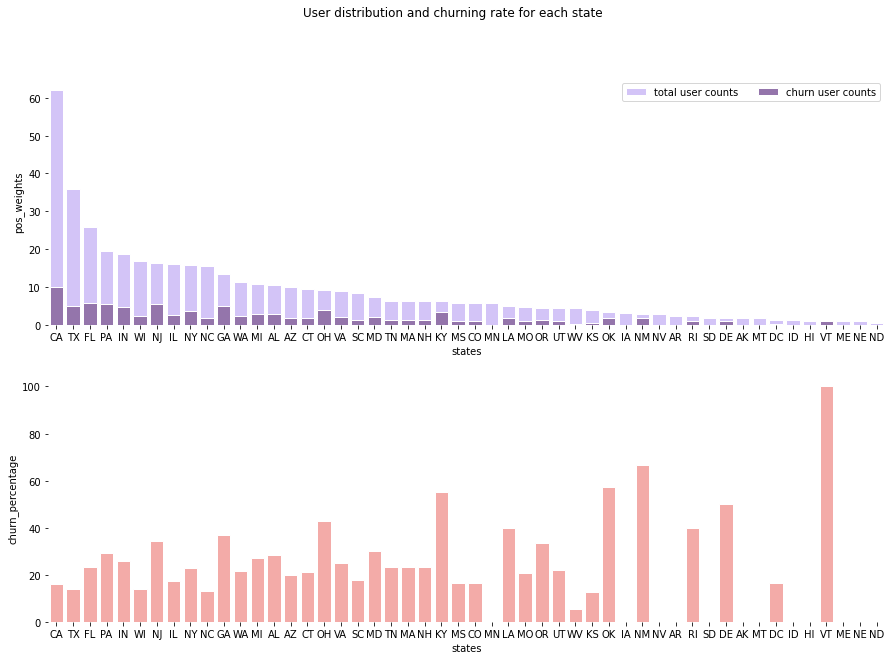

In [26]:
fig, ax = plt.subplots(2,1,figsize = (15,10))

# upper bar plot of positive user s count against total user s count 
sns.set_color_codes('pastel')
sns.barplot(x='states', y='total', data=user_states_pdf, \
            label='total user counts', color='m', edgecolor='w', ax=ax[0])

sns.set_color_codes('muted')
sns.barplot(x='states', y='pos_weights', data=user_states_pdf, \
            label='churn user counts', color='m', edgecolor='w', ax=ax[0])

#bottom bar plot of churn percentage
sns.set_color_codes('pastel')
sns.barplot(x='states', y='churn_percentage', data=user_states_pdf, \
            label='churn percentage', color='r', edgecolor='w', ax=ax[1])

ax[0].legend(ncol=2, loc='upper right')

sns.despine(left=True, bottom=True)
fig.suptitle('User distribution and churning rate for each state') # or plt.suptitle('Main title')
plt.show()

### What is the sparkify activity over time ?

   - **We want to understand the activity trends** of all users and specifically on users who churned their subscription. '
   - **We start counting the number of events per day**. 

In [27]:
# calculate the number of events triggered per day for negative and positive users
daily_activity_pdf = churn_df.select(F.date_trunc("day", "ts").alias("day"), "churn") \
                            .groupBy("day") \
                            .pivot('churn') \
                            .agg(F.count(F.col('day')).alias("count")) \
                            .orderBy("day") \
                            .toPandas()

# rename columns and calculate total activity over time
daily_activity_pdf = daily_activity_pdf.fillna(0).rename(columns={"0":"neg_counts", "1":"pos_counts"})
daily_activity_pdf['total'] = daily_activity_pdf['neg_counts'] + daily_activity_pdf['pos_counts']

   - In addition, we count the number of users who cancel their subscription everyday.

In [28]:
# count the number of churned subscribtions per day
churn_users_pdf = churn_df.filter(F.col("churn")==1) \
                         .groupBy('userId').agg(F.max(F.date_trunc("day", "ts").alias("day")).alias("churn_date")) \
                         .groupBy('churn_date').agg(F.count('userId').alias("churn_count")) \
                         .toPandas()

   - **We plot the macro-activity and the number of cancellation in function of time**
   - The positive users represent a large amount of the activity on sparkify although it decreases over time. Frequently, there are users cancelling their subscription although the numbers stay low despite some rare peaks. Up to 6 cancellation on a single day. 
   - **The activity follows a weekly cycle.**

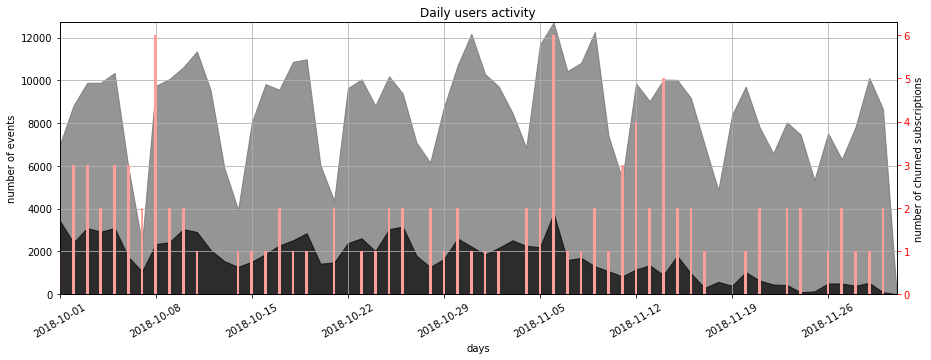

In [29]:
fig, ax = plt.subplots(1,1,figsize = (15,5))
ax2 = ax.twinx()

# filled line plot of the daily activity for all users
ax.fill_between(daily_activity_pdf['day'], daily_activity_pdf['total'], color="dimgray", alpha=0.7)
# filled line plot of the daily activity for positive users
ax.fill_between(daily_activity_pdf['day'], daily_activity_pdf['pos_counts'], color="black", alpha=0.7)
# superposed bar plot of the number on churned subscriptions per day
ax2.bar(churn_users_pdf['churn_date'], churn_users_pdf['churn_count'], width=0.2, color='r')

# plot configuration
ax.set_title("Daily users activity");
ax.set(xlabel="days", ylabel="number of events")
ax2.set(ylabel="number of churned subscriptions")
ax2.tick_params(axis='y', colors='red')
ax.grid()

# weekly ticks every monday for x-axis
ax.set_xlim(daily_activity_pdf['day'].min(), daily_activity_pdf['day'].max())
ax.set_ylim(0, daily_activity_pdf['total'].max())
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.tick_params(axis="x", rotation=30)

### What is the probability of churning given the gender of the user?

   - **We want to know which gender is more likely to churn their subscription**.
   - Between male and female, **we count how many churned in each category****

In [30]:
gender_churn_pdf = churn_df.groupBy("userId") \
                             .agg(F.max(F.col("gender")).alias("gender"), \
                                  F.max(F.col("churn")).alias("churn")) \
                             .groupBy("gender") \
                             .pivot("churn") \
                             .count() \
                             .toPandas()

   - **We calculate the chruning rate for each category and display the outcome**.
   - **The churning rate is equivalent for both male and females** 
   - There are 21% less females on the platform. Without any gender consideration, the churning rate reamins stable around 22 and 23%.

In [31]:
# rename columns and calculate percentge of churning given the gender
gender_churn_pdf = gender_churn_pdf.rename(columns={"0":"neg_counts", "1":"pos_counts"})
gender_churn_pdf['total'] = gender_churn_pdf['neg_counts'] + gender_churn_pdf['pos_counts']
gender_churn_pdf['pos_given_gender'] = gender_churn_pdf['pos_counts'] / gender_churn_pdf['total']
gender_churn_pdf = gender_churn_pdf.set_index('gender')

# display result
print(f"the probability of churnuing give that the gender is female: {round(gender_churn_pdf.loc['F','pos_given_gender'],2)}")
print(f"the probability of churnuing give that the gender is male: {round(gender_churn_pdf.loc['M','pos_given_gender'],2)}")
gender_churn_pdf

the probability of churnuing give that the gender is female: 0.23
the probability of churnuing give that the gender is male: 0.22


,neg_counts,pos_counts,total,pos_given_gender
gender,,,,
F,153,45,198,0.227273
M,196,54,250,0.216000


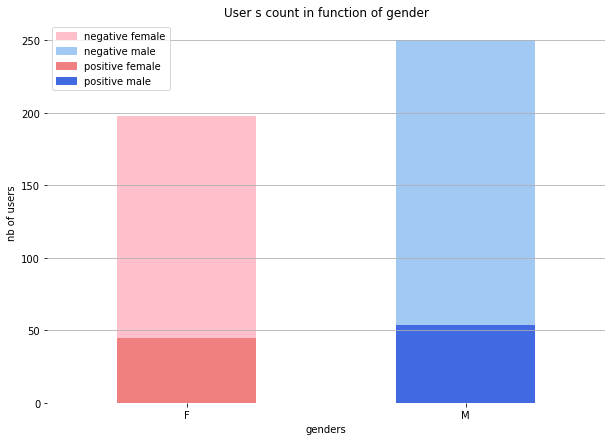

In [32]:
f, ax = plt.subplots(figsize = (10,7))

# set up legend
c = {'negative female':'pink',
     'negative male':'b',
     'positive female':'lightcoral',
     'positive male':'royalblue'}    

labels = list(c.keys())
handles = [plt.Rectangle((0,0),1,1, color=c[label]) for label in labels]

# barplot of total user count in function of gender
gender_churn_pdf.plot(kind='bar', y='total', \
                color = [c['negative female'], c['negative male']], \
                rot=0, ax=ax)

# barplot of positive user count in function of gender
gender_churn_pdf.plot(kind='bar', y='pos_counts', \
                color = [c['positive female'], c['positive male']], \
                rot=0, ax=ax)

# set plot configuration
sns.despine(left=True, bottom=True)
ax.legend(handles, labels)
ax.set_title("User s count in function of gender");
ax.set(xlabel="genders", ylabel="nb of users")
ax.grid(axis = 'y')

plt.show()

### What  is the activity per gender ?

   - **We want to understand which gender is the most active on the platform**. 
   - It is important to keep the time dimension to be sure there are no punctual perturbations skewing the distribution of data and leading to wrong conclusions. 
   - **We count the users activity for each gender and for each day**: ratio between number of events and number of users, for each day

In [33]:
# calculate the number of events triggered per day for males and females
gender_activity_pdf = churn_df.select(F.date_trunc("day", "ts").alias("day"), "gender", "userId") \
                            .groupBy("day") \
                            .pivot('gender') \
                            .agg(F.count(F.col('day')).alias("event_count"), \
                                 F.countDistinct(F.col('userId')).alias("user_count")) \
                            .withColumn("M_activity", F.col("M_event_count")/F.col("M_user_count")) \
                            .withColumn("F_activity", F.col("F_event_count")/F.col("F_user_count")) \
                            .toPandas()

   - **we transform data representation for using seaborn to full extend**. 

In [34]:
# melt genders for use hue option in seaborn
gender_activity_pdf = gender_activity_pdf.melt(id_vars=['day'], value_vars=['M_activity', 'F_activity'], var_name='genders', value_name='count')

   - **We plot  the daily gender´s activity over time**.
   - There are more males than females but **their activity is about the same**. 
   - It is worth noting that male s and female activities are not in phase. There is a slight lag as the peaks don't match up.

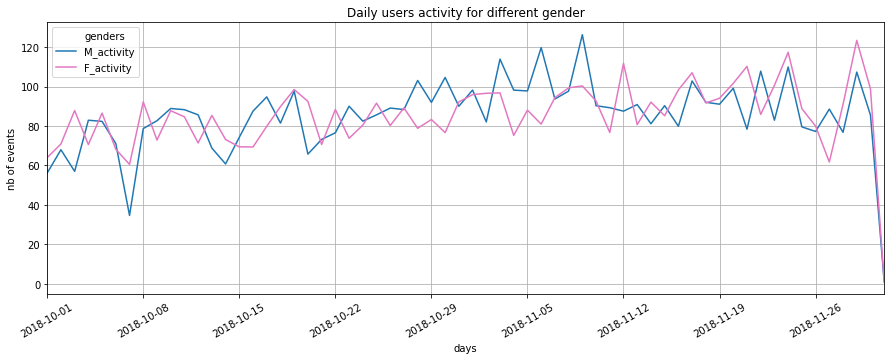

In [35]:
fig, ax = plt.subplots(1,1,figsize = (15,5))

# line plot of the daily activity for male users
sns.lineplot( x='day', y='count', hue='genders', data=gender_activity_pdf, palette=["C0", "C6"], ax=ax)

# set plot configuration
sns.set_palette(sns.color_palette("tab10"))
ax.set_title("Daily users activity for different gender");
ax.set(xlabel="days", ylabel="nb of events")
ax.grid()

# weekly ticks every monday for x-axis
ax.set_xlim(gender_activity_pdf['day'].min(), gender_activity_pdf['day'].max())
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.tick_params(axis="x", rotation=30, which='major')

### What is the probability of churning given the payment level of the user?

   - **We want to know which user is more likely to churn their subscription in function of their level of payment**.
   - Between "paid" and "free", **we count how many users churned in each category**. 
   - It is important to mention how these categories are constructed. **Users in paid category are users who once paid for sparkify**, even if they downgraded their subscription afterwards. In order to do so, we simply have to keep the maximum between "paid" and "free" (because "paid" > "free") for each user. 

In [36]:
level_churn_pdf = churn_df.groupBy("userId") \
                             .agg(F.max(F.col("level")).alias("level"), \
                                  F.max(F.col("churn")).alias("churn")) \
                             .groupBy("level") \
                             .pivot("churn") \
                             .count() \
                             .toPandas()

   - **We calculate the chruning rate for each category and display the outcome**.
   - **The churning rate is higher among users who once paid for sparkify**. 
   - Beyond, churning consideration, there are 60% less users who once paid for Sparkify.

In [37]:
# rename columns and calculate percentge of churning given the level
level_churn_pdf = level_churn_pdf.rename(columns={"0":"neg_counts", "1":"pos_counts"})
level_churn_pdf['total'] = level_churn_pdf['neg_counts'] + level_churn_pdf['pos_counts']
level_churn_pdf['pos_given_level'] = level_churn_pdf['pos_counts'] / level_churn_pdf['total']
level_churn_pdf = level_churn_pdf.set_index('level')

# display result
print(f"the probability of churnuing give that the level of payment is paid: {round(level_churn_pdf.loc['paid','pos_given_level'],2)}")
print(f"the probability of churnuing give that the level of payment is free: {round(level_churn_pdf.loc['free','pos_given_level'],2)}")
level_churn_pdf

the probability of churnuing give that the level of payment is paid: 0.23
the probability of churnuing give that the level of payment is free: 0.19


,neg_counts,pos_counts,total,pos_given_level
level,,,,
free,103,24,127,0.188976
paid,246,75,321,0.233645


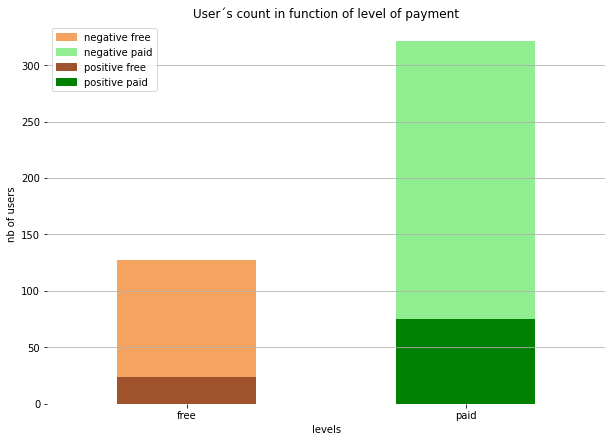

In [38]:
f, ax = plt.subplots(figsize = (10,7))

# set up legend
c = {'negative free':'sandybrown',
     'negative paid':'lightgreen',
     'positive free':'sienna',
     'positive paid':'green'}  

labels = list(c.keys())
handles = [plt.Rectangle((0,0),1,1, color=c[label]) for label in labels]

# barplot of total user count in function of level
level_churn_pdf.plot(kind='bar', y='total', \
                color = [c['negative free'], c['negative paid']], \
                rot=0, ax=ax)

# barplot of positive user count in function of level
level_churn_pdf.plot(kind='bar', y='pos_counts', \
                color = [c['positive free'], c['positive paid']], \
                rot=0, ax=ax)
ax.legend(handles, labels)

# set plot configuration
sns.despine(left=True, bottom=True)
ax.legend(handles, labels)
ax.set_title("User´s count in function of level of payment");
ax.set(xlabel="levels", ylabel="nb of users")
ax.grid(axis = 'y')

plt.show()

### What  is the activity per level of payment ?

   - **We want to understand whether the activity of the users has something to do with their level of payment**. 
   - It is important to keep the time dimension to be sure there are no punctual perturbations skewing the distribution of data and leading to wrong conclusions. 
   - **We count the users activity for each level and for each day**: ratio between number of events and number of users, for each day

In [39]:
# calculate the number of events triggered per day for negative and positive users
level_activity_pdf = churn_df.select(F.date_trunc("day", "ts").alias("day"), "level", "userId") \
                            .groupBy("day") \
                            .pivot('level') \
                            .agg(F.count(F.col('day')).alias("event_count"), \
                                 F.countDistinct(F.col('userId')).alias("user_count")) \
                            .withColumn("paid_activity", F.col("paid_event_count")/F.col("paid_user_count")) \
                            .withColumn("free_activity", F.col("free_event_count")/F.col("free_user_count")) \
                            .toPandas()

   - **we transform data representation for using seaborn to full extend**. 

In [40]:
# melt genders for use hue option in seaborn
level_activity_pdf = level_activity_pdf.melt(id_vars=['day'], value_vars=['paid_activity', 'free_activity'], var_name='levels', value_name='count')

   - **We plot  the daily activity for both level of payment over time**.
   - **The males are much more active than females**. They interact with Sparkify< twice more than female.

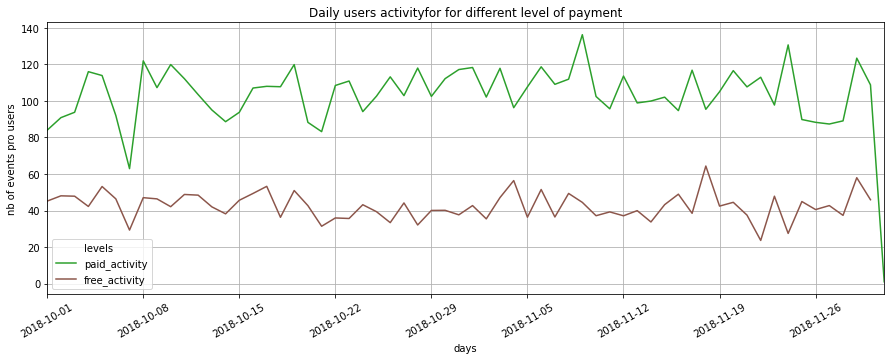

In [41]:
fig, ax = plt.subplots(1,1,figsize = (15,5))

# line plot of the daily activity for male users
sns.lineplot( x='day', y='count', hue='levels', data=level_activity_pdf, palette=["C2", "C5"], ax=ax)

# set plot configuration
sns.set_palette(sns.color_palette("tab10"))
ax.set_title("Daily users activityfor for different level of payment");
ax.set(xlabel="days", ylabel="nb of events pro users")
ax.grid()

# weekly ticks every monday for x-axis
ax.set_xlim(gender_activity_pdf['day'].min(), gender_activity_pdf['day'].max())
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.tick_params(axis="x", rotation=30, which='major')

### When users churn their subscription?

  - **We want to understand if the cancellation is time dependent**  
  - For positive users, we detect when each user emerges in the records for the first time (entry date) until he cancels his subscription.
  - We focus on the cancellation date for now. Later we will be able to evaluate if there is any correlation with the entry date. 

In [42]:
# calculate how oftem positive users churn their substriction per "week of the year" and per "day of the week"
churn_date_pdf = churn_df.filter(F.col('churn')==1) \
                            .groupBy("userId") \
                            .agg(F.min(F.col("ts")).alias("1st_activ_time"), \
                                 F.max(F.col("ts")).alias("churn_time")) \
                            .withColumn("1st_activ_week_of_year", F.weekofyear(F.col("1st_activ_time"))) \
                            .withColumn("1st_activ_day_of_week", F.dayofweek(F.col("1st_activ_time"))) \
                            .withColumn("week_of_year_churn", F.weekofyear(F.col("churn_time"))) \
                            .withColumn("day_of_week_churn", F.dayofweek(F.col("churn_time"))) \
                            .orderBy(F.col("day_of_week_churn")) \
                            .toPandas()

   - **we count how many users cancel their subscription every weeks**
   - **we count when it how often it happens within the weekdays**

In [43]:
# count the number of subscriptons chruned for each week of the year
weekly_churn_pdf = churn_date_pdf[['week_of_year_churn','userId']].groupby('week_of_year_churn').count().reset_index()

# count the number of subscriptons chruned for each day of the week
daily_churn_pdf = churn_date_pdf[['day_of_week_churn','userId']].groupby('day_of_week_churn').count().reset_index()

   - **We display the distribution of churns over the weeks** covering the duration of the data record. Besides, **We display the cyclic distribution of cancellation within a week**.
   - There are 5 weeks where the churn count is around 7 to 8. The other 4 week, it jumps to 12 to 16. It is almost twice but the reason is unknown. There is no trend nor pattern. We should run the record for a longer period of time. 
   - The daily churn distribution peaks in the middle of the week on wednesday. The churn subscriber count decay regularly around that day except for saturday where the numbers are high again.

/opt/ibm/conda/miniconda/lib/python/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


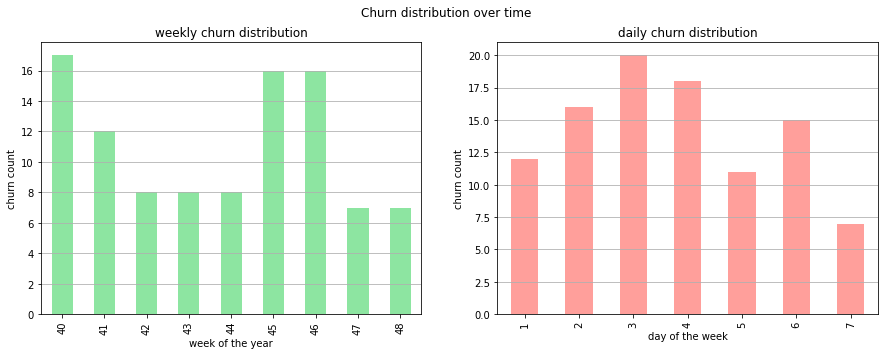

In [44]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

# barplot of the churn count for week of the year
weekly_churn_pdf.plot(kind='bar', x='week_of_year_churn', y='userId', color='g', \
                      title="weekly churn distribution", legend=False, ax=ax[0])
ax[0].set(xlabel="week of the year", ylabel="churn count")
ax[0].grid(axis = 'y')

# barplot of the churn count for each day of the week
daily_churn_pdf.plot(kind='bar', x='day_of_week_churn', y='userId', color='r', \
                     title="daily churn distribution", legend=False, ax=ax[1])

# set plot configuration
ax[1].set(xlabel="day of the week", ylabel="churn count")
ax[1].grid(axis = 'y')

# set main title
fig.suptitle('Churn distribution over time');

   - **We plot the correlation matrix between the week of cancellation and the week of first use**. 
   - The majority of positive users were already active from the very first week of record. We can assume  that these **users have subscribed even before the recording of the data actually started**. 

In [45]:
# check how the week of cancellation is correlated to the first week of activity on the platform
correlation_pdf = pd.pivot_table(churn_date_pdf, values='userId', index=['1st_activ_week_of_year'],columns=['week_of_year_churn'], aggfunc='count', fill_value=0)

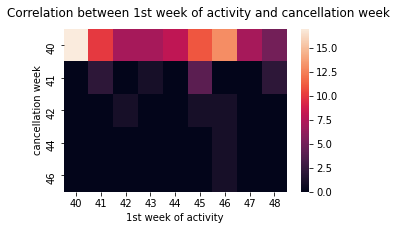

In [46]:
fig, ax = plt.subplots(1,1,figsize = (5,3))

#display the heatmap 
sns.heatmap(correlation_pdf, ax=ax);

# set plot configuration
ax.set(xlabel="1st week of activity", ylabel="cancellation week")

# set main title
fig.suptitle('Correlation between 1st week of activity and cancellation week');

### How long last a session ?

   - **We want to find out how long users interact with Sparkify**. In that regard, the "session" is the best unit for analyzing the duration of continuous interaction with the platform.  
   - **We calculate the duration of each sessions**: For each "sessionId," it corresponds to the timelase (delta) between the beginning (min time) of the session and the end (max time)

In [47]:
# measure the duration of each session opened every weeks and every days
session_delta_pdf = churn_df.groupBy("sessionId") \
                            .agg(F.min(F.col("ts")).alias("in_time"), \
                                 F.max(F.col("ts")).alias("out_time"), \
                                 F.max(F.col("churn")).alias("churn")) \
                            .withColumn("delta_hour", (F.col("out_time").cast("long") - F.col("in_time").cast("long"))/3600) \
                            .withColumn("week_of_year", F.weekofyear(F.col("in_time"))) \
                            .withColumn("day_of_week", F.dayofweek(F.col("in_time"))) \
                            .orderBy(F.col("day_of_week")) \
                            .toPandas()

   - **We describe the distribution of session duration for both positive and negative users**.
   - The distribution of **the session duration is widely spread**. There are indeed extremely long sessions, up to 60 days (1447h). On the other hand, some sessions are extremely short, just the time for visiting a single page.  
   - When we look at the difference between negative and positive users, **the session duration for positive users is more spread**. The median, the 3d quantile and the max seem to support that idea. 

In [48]:
print("Description of session duration")
pd.concat([session_delta_pdf.loc[session_delta_pdf['churn']==0, 'delta_hour'].describe(), \
           session_delta_pdf.loc[session_delta_pdf['churn']==1, 'delta_hour'].describe()], \
           keys=['negative','positive'], axis=1)

Description of session duration


,negative,positive
count,3398.000000,1072.000000
mean,119.948102,276.295156
std,318.666782,409.111098
min,0.000000,0.000000
25%,1.317986,2.704792
50%,3.978750,14.306667
75%,11.728403,517.846042
max,1427.228611,1447.938056


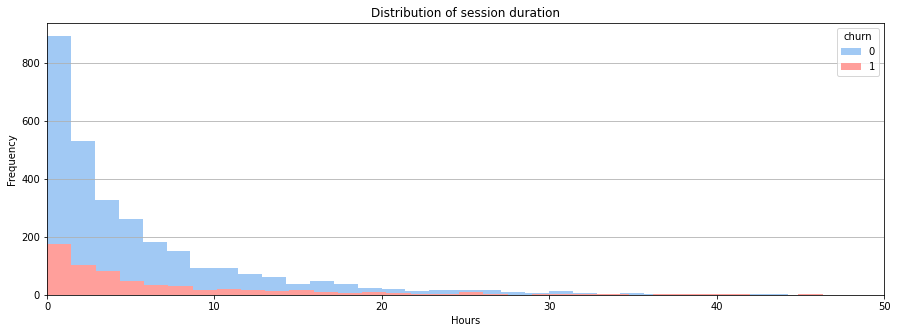

In [67]:
fig, ax = plt.subplots(1,1,figsize = (15,5))

# plot the distributon of session duration
session_delta_pdf[session_delta_pdf['churn']==0].plot(kind='hist', y='delta_hour', bins=1000, color='b', ax=ax);
session_delta_pdf[session_delta_pdf['churn']==1].plot(kind='hist', y='delta_hour', bins=1000, color='r', ax=ax);

# set plot configuration
ax.grid(axis = 'y')
ax.legend(["0", "1"], title="churn");
ax.set(xlabel="Hours", ylabel='Frequency', xlim=(0,50))
ax.set_title("Distribution of session duration");

   - **We plot the the duration of sessions for both positive and negative users over the week**
   - The weekly distribution of session duration spreads from week 40 to week 48. It is a total of 8 weeks where the sessions are around 800 hours long in the beginning and **decrease rapidly** to a few minutes at the end. The sane behavior can be observed for both negative and positive users although negative users sessions' duration drop even more rapidly over time. 

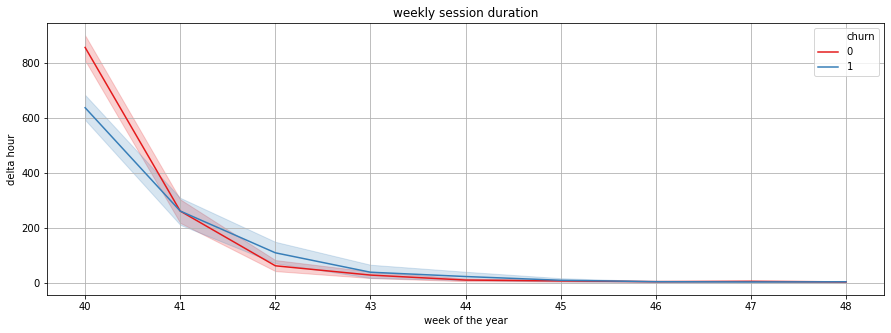

In [68]:
fig, ax = plt.subplots(1,1,figsize = (15,5))

# barplot of the duration per week, with confidence interval
sns.lineplot(x="week_of_year", y="delta_hour", hue="churn", data=session_delta_pdf, palette="Set1", ax=ax)

# set plot configuration
ax.grid()
ax.set(xlabel="week of the year", ylabel='delta hour')
ax.set_title("weekly session duration");

   - Session duration is a key  parameter. It indicates how users interact with the platform. Such a drastic change over time is quite surprising as the activity on the platform seems to remain stable. 
   - **We plot the number of new session opened per week**.
   - We observe that the number of sessions related to positive users decreases exponentially again as time increases. 
   - We could impute this phenomena to the simple fact of observing data over a short period. Positive users usually stay on the platform quite long. During the period of observation, **The amount of users identified as positive is not getting refilled over time**. 
   - The users joining sparkify in this timeframe may churn their contract beyond the record end date.  They pass through our radar. The number of positive reach users reaches 0 before we stop the recording, and so it is for the number of sessions.

In [110]:
# we calculate the number of sessions opened every week for both positive and negative users
nb_session_pdf = session_delta_pdf[['week_of_year', 'churn','sessionId']].groupby(['week_of_year', 'churn']).count().reset_index()

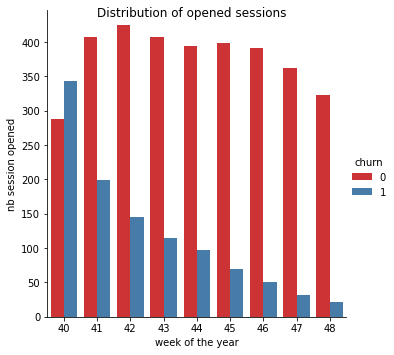

In [127]:
# barplot of the duration per day, with confidence interval
g = sns.catplot(x = 'week_of_year', y='sessionId', hue = 'churn', data=nb_session_pdf, palette="Set1", kind='bar')

# set plot configuration
g.fig.suptitle('Distribution of opened sessions')
g.set_axis_labels("week of the year", "nb session opened");

In [125]:
# measure the duration of each session opened every weeks and every days
delta_pdf = churn_df.select(F.col("length"), F.col("churn")).toPandas()

### What artist users who churn listen to ?

   - **We want to know if there's a noticeable difference between positive and negative users around the question of music taste**. 
   - **We count how many distinct users listen to each artist**.

In [126]:
artist_churn_pdf = churn_df.groupBy("artist") \
                             .pivot("churn") \
                             .agg(F.countDistinct(F.col("userId")).alias("count")) \
                             .toPandas()

artist_churn_pdf = artist_churn_pdf.rename(columns={"0":"neg_counts", "1":"pos_counts"})

   - **we list the 20 top most listened artists** for both positive and negative users.
   - **We deduce the name of artists that positive users do not share with negative users**. However,  the set changes as the number of artists considered changes . For instance, the top50 would hand out different results. It depends where we set the cursor. 


In [127]:
top_20_pos_pdf = artist_churn_pdf[["artist", "pos_counts"]].sort_values(by="pos_counts", ascending=False).dropna().head(20).set_index('artist')
top_20_neg_pdf = artist_churn_pdf[["artist", "neg_counts"]].sort_values(by="neg_counts", ascending=False).dropna().head(20).set_index('artist')
print("positive users have exclusively in their top 20: ",set(top_20_pos_pdf.index) - set(top_20_neg_pdf.index))

positive users have exclusively in their top 20:  {'Harmonia', 'Metallica', "Guns N' Roses"}


   - A simple difference between the 2 lists is not giving a good appreciation on testing divergence.
   - **We leverage the frequency of occurrence of each artist to construct word clouds**. The bigger is the name, the more popular the artist is. 
   - The main difference is that positive users particularly like Dwight Yoakam. He is a Pioneer of country music. They also like Florence and the machine. It is an indie rock band. 
   - This technique is not exhaustive but it can help the owner of the platform to decide  on new content for keeping positive users in the circuit. 

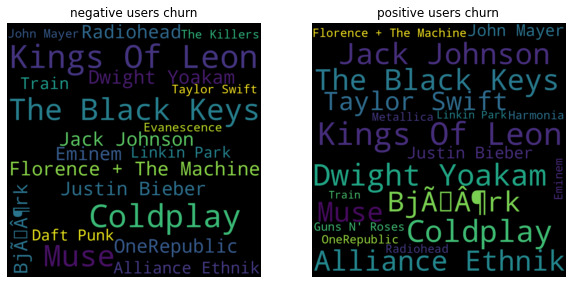

In [128]:
f, ax = plt.subplots(1,2,figsize = (10,10))

# word cloud plot of artist names the neagative users listen to
wordcloud_neg = WordCloud(width=1000, height=1000)
wordcloud_neg.generate_from_frequencies(frequencies=top_20_neg_pdf.to_dict('dict')['neg_counts'])
ax[0].imshow(wordcloud_neg, interpolation="bilinear")
ax[0].set_title('negative users churn')
ax[0].axis("off")

# word cloud plot of artist names the positive listen to
wordcloud_pos = WordCloud(width=1000, height=1000)
wordcloud_pos.generate_from_frequencies(frequencies=top_20_pos_pdf.to_dict('dict')['pos_counts'])
ax[1].imshow(wordcloud_pos, interpolation="bilinear")
ax[1].set_title('positive users churn')
ax[1].axis("off")

plt.show()

# 4. Feature Engineering 

Since we have familiarized with the data, we can build out the features we find promising to train our model on. However, **rather than building features directly, we will build a feature factory** to be reused.

We start this journey with the raw data we are given. These data cannot be exploited yet. They need to be transformed to become training material for some ML algorithm. In this logic, **we build a featurization pipeline with transformers only**. When training time will come, we should be able to append any estimator. 

The role of this pipeline is to extract, transform, and vectorize features. 

- **We import most of the libraries needed for building the pipeline and to some extent, the overall ML model**.

In [147]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml import Pipeline

- **We preprocess the data according to what was done during data exploration**.
- As we enter the pure ML part, we take care of renaming the "churn" column into "label"

In [148]:
# we do the relevant operation identified earlier for extracing informatrion from non-numerical data
churn_df = churn_df.withColumn("day_of_week", F.dayofweek(F.col("ts")))
churn_df = churn_df.withColumn('OS', F.regexp_extract(F.col('userAgent'), r"\(([\w\d\s.]+)(;|\))", 1))
churn_df = churn_df.withColumn('states', F.regexp_extract(F.col('location'), r"([A-Za-z\-]+), ([A-Za-z\-]+)", 2)) 
churn_df = churn_df.withColumn('states_list', F.split(F.col('states'),'-'), )

# it is important to rename the churn column inot label for the later use of BinaryClassificationEvaluator 
churn_df = churn_df.withColumnRenamed("churn","label")

- **We create all different building blocks constituting the featurization pipeline**.
- In sequence:
   - We use string indexers for encoding string-like data into cardinal data but ordinal. 
   - We have to use one hot encoder for transforming these ordinal data into nominal data. This way, we get rid of the quantitative relationship between categories. 
   - So far, the features are either 0 or 1 but we also want to use the "length" column despite its large variation range.  Mixing high and low range features may disrupt some ML algorithms (MPC for instance) therefore rescaled it between 0 and 1 thanks to a min max scaler.
    - The states are very important. In order to grasp the idea that users can be spread over several states at the same time, we decided to use some NLP technique. Every state becomes a feature, and all together, they form a vocabulary. we set one in the states where he is at.
    - the ultimate step is to assemble all the features into a single column of vectors.
- **We end up with  80 features in total**. 

In [149]:
# string indexer attributes numbers to distinct values in column of interst
SI_OS = StringIndexer(inputCol='OS', outputCol='OS_index', handleInvalid='skip')
SI_gender = StringIndexer(inputCol='gender', outputCol='gender_index', handleInvalid='skip')
SI_level = StringIndexer(inputCol='level', outputCol='level_index', handleInvalid='skip')
SI_page = StringIndexer(inputCol='page', outputCol='page_index', handleInvalid='skip')

# scalre the length between 0 and 1  like the rest of the features
VA_length = VectorAssembler(inputCols=['length'], outputCol="length_vec", handleInvalid='skip')
MM_length = MinMaxScaler(inputCol='length_vec', outputCol="length_scaled")
pipeline_length = Pipeline(stages=[VA_length, MM_length])

# one hot encode categorical data that are not ordinal
OHE = OneHotEncoder(inputCols = ['OS_index', 'gender_index', 'level_index', 'page_index'], \
                    outputCols = ['OS_OHE', 'gender_OHE', 'level_OHE', 'page_OHE'])

# cuse count bector to identify all the states where the user has travelled to
CV = CountVectorizer(inputCol="states_list", outputCol="states_CV")

# list te features to be considered and assemble them into a vector
featureCols = ['OS_OHE', 'gender_OHE', 'level_OHE', 'page_OHE', 'states_CV', 'length_scaled']
VA = VectorAssembler(inputCols=featureCols, outputCol='features', handleInvalid='skip')

# define the featurization pipeline: list of previous transformers
pipeline_featurization = Pipeline(stages=[SI_OS, SI_gender, SI_level, SI_page, OHE, CV, pipeline_length, VA])

# 5. Modeling

Now we have the features, we can focus on building ML models. **We want to predict if someone is about to churn its subscription based on a single row input**. 
The work done previously comes into play. The featurization pipeline became the first part of our final model. The last part is the estimator but yet, we have to decide which one. 
**We will try different ML algorithms** and pick the best one. It implies training, tuning, testing, evaluation and comparison.

The eligible candidates are:
- Gradient Boost
- Naive bayes
- Support Vector Machine
- Multi Layer Perceptron

- First of all, **we need ot split the data between train (80%) and test (20%) set.**

In [150]:
# split dataset into train set 80% and test set 20%
train_df, test_df = churn_df.randomSplit([0.8, 0.2], seed=42)

- We will try different models so **we define a function calculating relevant of metrics** to be able to compare them. This function will be reused for every models.

- the metrics are:
    - **Accuracy** is defined as simply the number of correctly categorized examples divided by the total number of examples. Accuracy can be useful but does not take into account the subtleties of class imbalances, or differing costs of false negatives and false positives.
    - **Precision** is the fraction of true positive examples among the examples that the model classified as positive. In other words, the number of true positives divided by the number of false positives plus true positives.
    - **Recall** is the fraction of examples classified as positive, among the total number of positive examples. In other words, the number of true positives divided by the number of true positives plus false negatives.
    - **F-score** is a way of combining the precision and recall of the model. It is defined as the harmonic mean of the model’s precision and recall.
    - **AUC** stands for "Area under the ROC Curve." It measures the entire two-dimensional area underneath the entire ROC curve is as the probability that the model ranks a random positive example more highly than a random negative example.
    
link to definition source [[1](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)] [[2](https://deepai.org/machine-learning-glossary-and-terms/f-score)]

In [151]:
def evaluation(model, df):
    """Calculate metrics for evalutaion of any models fitted on given data"""
    
    metrics = {}

    # get predictions
    prediction = model.transform(df)
    
    # calculate the elements of the confusion matrix
    metrics['TN'] = prediction.filter('prediction = 0 AND label = prediction').count()
    metrics['TP'] = prediction.filter('prediction = 1 AND label = prediction').count()
    metrics['FN'] = prediction.filter('prediction = 0 AND label <> prediction').count()
    metrics['FP'] = prediction.filter('prediction = 1 AND label <> prediction').count()
    
    # build confusion matrix
    metrics['decision_matrix'] = prediction.groupBy('label', 'prediction').count().toPandas()
    metrics['decision_matrix'] = pd.pivot_table( metrics['decision_matrix'], values='count', index=['prediction'],columns=['label'], fill_value=0)

    # calculate metrics by the confusion matrix
    metrics['accuracy'] = (metrics['TN'] + metrics['TP']) / (metrics['TN'] + metrics['TP'] + metrics['FN'] + metrics['FP'])
    metrics['precision'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])
    metrics['recall'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])
    metrics['F'] =  2 * (metrics['precision']*metrics['recall']) / (metrics['precision'] + metrics['recall'])

    # calculate auc
    evaluator = BinaryClassificationEvaluator()
    metrics['auc'] = evaluator.evaluate(prediction, {evaluator.metricName: 'areaUnderROC'})
    
    return metrics

def plot_results(metrics):
    """Print metrics and plot heatmap of decision matrix"""
    
    # print results 
    print('precision: %0.3f' % metrics['precision'])
    print('recall: %0.3f' % metrics['recall'])
    print('accuracy: %0.3f' % metrics['accuracy'])
    print('F1 score: %0.3f' % metrics['accuracy'])
    print('AUC: %0.3f' % metrics['auc'])
    
    fig, ax = plt.subplots(1,1,figsize = (5,3))
    
    # plot confusion matrix
    sns.heatmap(metrics['decision_matrix'], annot=True, fmt="d", ax = ax)


### Model 1: Gradient Boost
   - **We set up the estimator, assemble the ML pipeline, define the parameter space for tuning, and train the model**.
   - Gradient-boosted trees (GBTs) are a popular classification and regression method using ensembles of decision trees.

In [152]:
from pyspark.ml.classification import GBTClassifier

# create Gradient Boost  model
GBT = GBTClassifier(featuresCol="features", labelCol="label", seed=42)

# create full pipeline, just append model to featurization pipeline
pipeline_GBT = Pipeline(stages=[pipeline_featurization, GBT])

# set parameter options
paramGrid_GBT = ParamGridBuilder()\
    .addGrid(GBT.maxIter, [25, 50]) \
    .addGrid(GBT.minInstancesPerNode, [1, 2])\
    .addGrid(GBT.maxDepth, [5, 10])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# 90% of the data will be used for training, 10% for validation.
TVS_GBT = TrainValidationSplit(estimator=pipeline_GBT,
                           estimatorParamMaps=paramGrid_GBT,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.9) 

# fit model on train data
model_GBT = TVS_GBT.fit(train_df)

   - **We evaluate the model and print the results**

In [153]:
# evaluate model on test data
metrics_GBT = evaluation(model_GBT, test_df)

precision: 0.934
recall: 0.718
accuracy: 0.935
F1 score: 0.935
AUC: 0.979


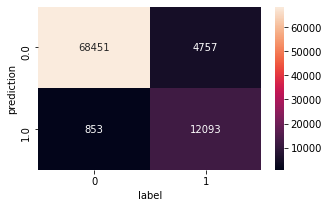

In [154]:
# plot results
plot_results(metrics_GBT)

### Model 2: Naive Bayes
   - **We set up the estimator, assemble the ML pipeline, define the parameter space for tuning, and train the model**.
   - Naive Bayes classifiers are a family of simple probabilistic, multiclass classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between every pair of features.

In [159]:
from pyspark.ml.classification import NaiveBayes

# create Naive Bayse model
NB = NaiveBayes(featuresCol='features', labelCol='label')

# create full pipeline, just append model to featurization pipeline
pipeline_NB = Pipeline(stages=[pipeline_featurization, NB])

# set parameter options
paramGrid_NB = ParamGridBuilder()\
    .addGrid(NB.smoothing, [0.5, 1]) \
    .addGrid(NB.modelType , ["multinomial", "gaussian"])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# 90% of the data will be used for training, 10% for validation.
TVS_NB = TrainValidationSplit(estimator=pipeline_NB,
                           estimatorParamMaps=paramGrid_NB,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.9) 

# fit model on train data
model_NB = TVS_NB.fit(train_df)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f412d8e97a0>
Traceback (most recent call last):
  File "/opt/ibm/conda/miniconda/lib/python/site-packages/pyspark/ml/wrapper.py", line 42, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'NaiveBayes' object has no attribute '_java_obj'


   - **We evaluate the model and print the results**

In [174]:
# evaluate model on test data
metrics_NB = evaluation(model_NB, test_df)

precision: 0.224
recall: 0.989
accuracy: 0.328
F1 score: 0.328
AUC: 0.587


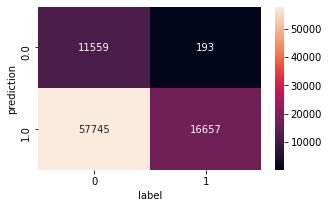

In [176]:
# plot results
plot_results(metrics_NB)

### Model 3: Linear Support Vector Machine
   - **We set up the estimator, assemble the ML pipeline, define the parameter space for tuning, and train the model**.
   - A support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space for separating negative from positive data.

In [179]:
from pyspark.ml.classification import LinearSVC

# # create Support vector Machine model
LSVC = LinearSVC(featuresCol='features', labelCol='label')

# create full pipeline, just append model to featurization pipeline
pipeline_LSVC = Pipeline(stages=[pipeline_featurization, LSVC])

# set parameter options
paramGrid_LSVC = ParamGridBuilder()\
    .addGrid(LSVC.maxIter, [25, 50]) \
    .addGrid(LSVC.tol, [0.01, 0.1])\
    .addGrid(LSVC.regParam, [0.1, 0.2])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# 90% of the data will be used for training, 10% for validation.
TVS_LSVC = TrainValidationSplit(estimator=pipeline_LSVC,
                           estimatorParamMaps=paramGrid_LSVC,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.9) 

# Run TrainValidationSplit, and choose the best set of parameters.
model_LSVC = TVS_LSVC.fit(train_df)

   - **We evaluate the model and print the results**

In [181]:
# evaluate model on test data
metrics_LSVC = evaluation(model_LSVC, test_df)

precision: 0.809
recall: 0.155
accuracy: 0.828
F1 score: 0.828
AUC: 0.713


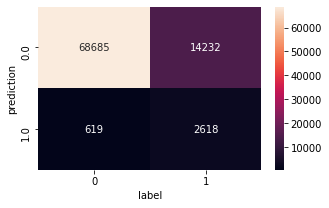

In [182]:
# plot results
plot_results(metrics_LSVC)

### Model 4: Multi Layer Perceptron
   - **We set up the estimator, assemble the ML pipeline, define the parameter space for tuning, and train the model**.
   - Multilayer perceptron classifier (MLPC) is a classifier based on the feedforward artificial neural network. MLPC consists of multiple layers of nodes. Each layer is fully connected to the next layer in the network.

In [184]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# create Multi Layer Perception model
MPC = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', seed=42)

# create full pipeline, just append model to featurization pipeline
pipeline_MPC = Pipeline(stages=[pipeline_featurization, MPC])

# set parameter options
paramGrid_MPC = ParamGridBuilder()\
    .addGrid(MPC.layers, [[80,40,20,2]])\
    .addGrid(MPC.maxIter, [25, 50])\
    .addGrid(MPC.solver, ['l-bfgs', 'gd'])\
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# 90% of the data will be used for training, 10% for validation.
TVS_MPC = TrainValidationSplit(estimator=pipeline_MPC,
                           estimatorParamMaps=paramGrid_MPC,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.9) # 90% of the data will be used for training, 10% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model_MPC = TVS_MPC.fit(train_df)


   - **We evaluate the model and print the results**

In [185]:
# evaluate model on test data
metrics_MPC = evaluation(model_MPC, test_df)

precision: 0.791
recall: 0.572
accuracy: 0.887
F1 score: 0.887
AUC: 0.903


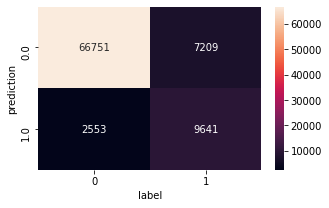

In [186]:
# plot results
plot_results(metrics_MPC)

### Model Synthesis
   - **We put the performance metrics of each model side by side**. 
   - **The gradient-boost tree outperforms other classifiers for almost all metrics**. When  it identifies some user as positive, it is often right. A larger proportion of positive users are not recognized as such but it's okay. The recall is relatively high. 
   - NB recall is even higher but the reason why it does so well is because it classifies too many users as positive, far beyond the actual ones. This is why the precision is so bad in return. 0.58 AUC indicates that classification is close to random. This model does not deal well with the unbalanced nature of the data, especially if the balance has changed between training and test data.
   - Unlike NB, MPC and LSVC have similar performance in terms of precision but the recall is too low. For LSVC in particular. The model is precise because it classifies just a few users as positive correctly. It misses too many users going to churn their subscription. 
   - **Recall is the most important metric. A high recall  ensures that we could reach out most of the users before they actually churn their subscription with some advertisement for instance. Now precision is also important to guarantee that we do not import the wrong people**.


In [210]:
# set color map for comparing coefficients
cm = sns.light_palette("green", as_cmap=True)

# present metrics for all models side by side in a styled data frame
pd.DataFrame([metrics_GBT, metrics_NB, metrics_LSVC, metrics_MPC], \
             columns=['accuracy', 'precision', 'recall', 'F', 'auc'], \
             index=['model_GBT', 'model_NB', 'model_LSVC', 'model_MPC']).T \
        .style.background_gradient(cmap = cm, axis=0)

,model_GBT,model_NB,model_LSVC,model_MPC
accuracy,0.934884,0.327507,0.827623,0.886691
precision,0.934111,0.223878,0.808774,0.790635
recall,0.717685,0.988546,0.155371,0.572166
F,0.811720,0.365077,0.260666,0.663889
auc,0.979303,0.587404,0.712967,0.902643


# 6. Summary

As we started this project, **we were asked to identify users before they cancel their subscription** from Sparkify. **We have set up a plan and a process to aim at this goal**. 
- We have begun this journey with data cleaning. **We could spot a large chunk of data where users were going missing**. We assumed they never subscribed to sparkify therefore they were out of scope. 
- Data explanation was certainly the most challenging part. **It was difficult to grasp dependencies between data as they keep changing over time**. Also the period of observation is too short for characterizing positive users over time as their number kept decreasing. The most visible trait of users' behaviour is their weekly interaction cycle with the platform. We tried to analyze the data under that angle and found some interesting behavior about the duration of sessions week after weeks. Finally, We used some NLP techniques for determining the position of the users and for finding out the kind artists they like. 
- We used our previous investigation on data for selecting interesting raw features. **We built a pipeline for transforming raw features into exploitable ones for ML activites**. We designed a standalone featurization pipeline for the sake of modularity. It becomes. 
- For modelling, **we considered 4 AI algorithms**. Each algorithm served the creation of 4 distinct ML Pipelines composed with their respective estimators and the featurizatin pipeline. Each model was given a  grid hyper-parameters for tuning. Only the best combination survives the validation step. Finally all models were tested and compared against some metrics. It is important to figure out what metrics are important to us in order to elect the best algorithms. 
- **Gradient boosted tree is by far the best algorithm. it shows high performances across all metrics**.

**practical observations**:
- working with geopandas in the IBM environment was not possible because python libraries do not match up with the current setup.
- The "pivot" function was essential for aggregating data around some features (churn flag).
- Regular expressions were very handy for creating new features out of text.
